
Selected Best Beta: 0.02154
Beta Candidates and p-values:
  c: 50.00000 → Beta: 10.77217 → p_train: 0.5842, p_test: 0.8317, |Diff|: 0.2475
  c: 20.00000 → Beta: 4.30887 → p_train: 0.9901, p_test: 0.9208, |Diff|: 0.0693
  c: 10.00000 → Beta: 2.15443 → p_train: 0.4158, p_test: 0.9307, |Diff|: 0.5149
  c: 0.10000 → Beta: 0.02154 → p_train: 0.9802, p_test: 0.9901, |Diff|: 0.0099
  c: 0.00100 → Beta: 0.00022 → p_train: 0.6238, p_test: 0.7327, |Diff|: 0.1089
  c: 0.00000 → Beta: 0.00000 → p_train: 0.9802, p_test: 0.9505, |Diff|: 0.0297
  c: 0.00000 → Beta: 0.00000 → p_train: 0.8812, p_test: 0.6931, |Diff|: 0.1881
  c: 0.00000 → Beta: 0.00000 → p_train: 0.7624, p_test: 0.9802, |Diff|: 0.2178
Moment Order: 5, mu: 0.0, Best Beta: 0.02154434690031884

Selected Best Beta: 0.00000
Beta Candidates and p-values:
  c: 50.00000 → Beta: 10.77217 → p_train: 0.7129, p_test: 0.9901, |Diff|: 0.2772
  c: 20.00000 → Beta: 4.30887 → p_train: 0.1089, p_test: 0.9604, |Diff|: 0.8515
  c: 10.00000 → Beta: 2.1544

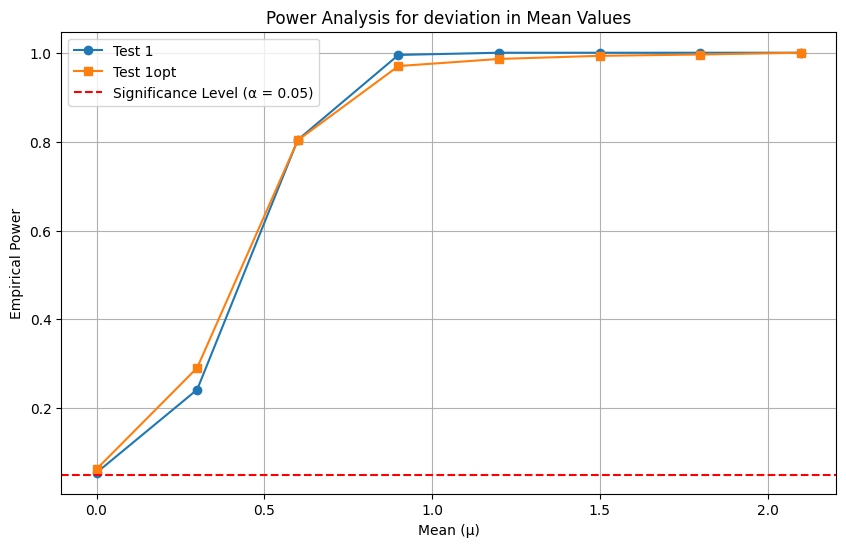

Mean: 0.0 Moment: 5
0           
0.000000e+00    146
2.154435e-07    134
2.154435e-02    126
2.154435e-04    125
4.308869e+00    121
1.077217e+01    120
2.154435e-10    115
2.154435e+00    113
Name: count, dtype: int64
Mean: 0.3 Moment: 5
0           
2.154435e-07    145
0.000000e+00    133
2.154435e-04    133
2.154435e-10    129
2.154435e-02    122
4.308869e+00    115
1.077217e+01    112
2.154435e+00    111
Name: count, dtype: int64
Mean: 0.6 Moment: 5
0           
0.000000e+00    142
4.308869e+00    134
2.154435e-10    132
2.154435e-07    128
2.154435e+00    124
2.154435e-04    122
2.154435e-02    120
1.077217e+01     98
Name: count, dtype: int64
Mean: 0.8999999999999999 Moment: 5
0           
2.154435e-07    148
0.000000e+00    144
2.154435e+00    128
1.077217e+01    125
2.154435e-10    122
2.154435e-02    118
2.154435e-04    113
4.308869e+00    102
Name: count, dtype: int64
Mean: 1.2 Moment: 5
0           
2.154435e-10    146
2.154435e-07    132
4.308869e+00    129
2.154435e+00    

In [8]:
######################################################################################
# Testing the power of the test under deviations from the null:
# Data-generating process (DGP) ∼ N(μ, 1), while the null hypothesis assumes N(0, 1)
#####################################################################################


import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import pandas as pd  
import seaborn as sns

# Set the seed for NumPy random number generation
np.random.seed(1234)  

# Parameters
N = 100           # Sample size
T = 100           # Length of bootstrap samples
S = 8             # Number of simulations
R = 100          # Number of bootstrap samples
alpha = 0.05      # Significance level
moment_order = 5 # Order of moments to consider
M = 1000         # Number of repetitions for empirical size
mu_values = np.arange(0, 2.1, 0.3)  # Range of means to test
c_values = [50,20,10, 10**-1, 10**-3, 10**-6,10**-9,0]  # Different c values for beta calculation


#Function to compute higher-order moments
def compute_moments(data, order):
    return np.mean(data ** order)

# Function to compute the test statistic for  Test 1 
def calculate_test_statistic_1(psi, psi_bar):
        diff = psi - psi_bar
        transformed = diff
        return np.dot(transformed, transformed)

# Function to compute the test statistic for  Test 1opt
def calculate_test_statistic_1opt(psi, psi_bar, K_inv_half):
        diff = psi - psi_bar
        transformed = K_inv_half @ diff
        return np.dot(transformed, transformed)

# See Antoine & Sun(2024) for formula to calculate K_N - covariance of the distance function 
def compute_kernel(matrix, sample_size):
    moment_order = matrix.shape[1]
    kernel = np.zeros((moment_order, moment_order))
    means = np.mean(matrix, axis=0)
    for h1 in range(moment_order):
        for h2 in range(moment_order):
            diff1 = matrix[:, h1] - means[h1]
            diff2 = matrix[:, h2] - means[h2]
            kernel[h1, h2] = np.sum(diff1 * diff2) / sample_size
    return kernel


# Function to select optimal c* and beta* 
def select_optimal_beta(N, c_values, moment_order, S, R, true_data):
    np.random.shuffle(true_data)
    tilde_N = int(2 * N / 3)
    train_data = true_data[:tilde_N]
    test_data = true_data[tilde_N:]
    N_test = N - tilde_N


    all_candidates = []

    for c in c_values:
        beta_train = c / (tilde_N ** (1/3))
        beta_test = c / (N_test ** (1/3))

        # Using the training sample compute p_train(c) 
        psi_train = np.array([compute_moments(train_data, h) for h in range(1, moment_order + 1)])

        psi_s_train = np.array([
            [compute_moments(np.random.normal(0, 1, tilde_N), h) for h in range(1, moment_order + 1)]
            for _ in range(S)
        ])
        psi_bar_s_train = np.mean(psi_s_train, axis=0)

        psi_r_train = np.array([
            [compute_moments(np.random.normal(0, 1, tilde_N), h) for h in range(1, moment_order + 1)]
            for _ in range(R)
        ])

        # Compute the weighted matrix on the training sample
        K_train = compute_kernel(psi_s_train, tilde_N)
        K_square = K_train @ K_train
        K_c_inv_half_train = np.linalg.pinv(K_square + beta_train * np.eye(moment_order)) @ K_train ##Optimal Weight##

        W_train = calculate_test_statistic_1opt(psi_train, psi_bar_s_train, K_c_inv_half_train)

        W_r_train = np.array([
            calculate_test_statistic_1opt(psi_r_train[i], psi_bar_s_train, K_c_inv_half_train)
            for i in range(R)
        ])
        p_value_train = (np.sum(W_r_train >= W_train) + 1) / (R + 1)

        # Using the testing sample compute p_test(c) 
        psi_test = np.array([compute_moments(test_data, h) for h in range(1, moment_order + 1)])

        psi_s_test = np.array([
            [compute_moments(np.random.normal(0, 1, N_test), h) for h in range(1, moment_order + 1)]
            for _ in range(S)
        ])
        psi_bar_s_test = np.mean(psi_s_test, axis=0)

        psi_r_test = np.array([
            [compute_moments(np.random.normal(0, 1, N_test), h) for h in range(1, moment_order + 1)]
            for _ in range(R)
        ])

        #Compute the weighted matrix on the testing sample
        K_test = compute_kernel(psi_r_test, N_test)
        K_square_test = K_test @ K_test
        K_c_inv_half_test = np.linalg.pinv(K_square_test + beta_test * np.eye(moment_order)) @ K_test ##Optimal Weight##

        W_test = calculate_test_statistic_1opt(psi_test, psi_bar_s_test, K_c_inv_half_test)

        W_r_test = np.array([
            calculate_test_statistic_1opt(psi_r_test[i], psi_bar_s_test, K_c_inv_half_test)
            for i in range(R)
        ])
        p_value_test = (np.sum(W_r_test >= W_test) + 1) / (R + 1)

        # abs_diff = abs(p_value_train - p_value_test)
        # all_candidates.append((c / (N ** (1/3)), p_value_train, p_value_test, abs_diff))
        abs_diff = abs(p_value_train - p_value_test)
        beta = c / (N ** (1/3))
        all_candidates.append((c, beta, p_value_train, p_value_test, abs_diff))

    # Find (c, beta) that minimizes |p_train(c) - p_test(c)|
    best_candidate = min(all_candidates, key=lambda x: (x[4], x[1]))
    #best_beta = min(all_candidates, key=lambda x: (x[3], x[0]))[0]
    best_c, best_beta, best_p_train, best_p_test, best_diff = best_candidate
    
    print(f"\nSelected Best Beta: {best_beta:.5f}")
    print("Beta Candidates and p-values:")
    for c, beta, p_train, p_test, diff in all_candidates:
        print(f"  c: {c:.5f} → Beta: {beta:.5f} → p_train: {p_train:.4f}, p_test: {p_test:.4f}, |Diff|: {diff:.4f}")

    
    return best_beta



# Initialize dictionary to store best beta results
best_beta_results = {mu: {moment_order: [] for moment_order in range(1, moment_order + 1)} for mu in mu_values}

# Perform specification testing for both test statistic specified i.e Test 1 and Test 1opt
power_test_1 = []
power_test_1opt = []

for mu in mu_values:
    rejected_count_1 = 0
    rejected_count_1opt = 0
    for _ in range(M):
        # Generate data to test for deviation of the mean from 0
        observed_data = np.random.normal(mu, 1, size=N)

        # Calculate the Auxiliary statistic
        observed_psi = np.array([compute_moments(observed_data, order) for order in range(1, moment_order + 1)])

        
        # Data for calculating optimal weight - Note: we use the true data to calculate the optimal weighting matrix 
        true_data1 = np.random.normal(0, 1, size=N)

        # Select the optimal beta only for Test 1 opt
        best_beta = select_optimal_beta(N, c_values, moment_order, S, R, true_data1)

        # Store the best beta value for this moment order and mu
        best_beta_results[mu][moment_order].append(best_beta)
            
        # Print the best_beta for the current iteration
        print(f"Moment Order: {moment_order}, mu: {mu}, Best Beta: {best_beta}")

        psi_s = np.array([
            [compute_moments(np.random.normal(0, 1, N), h) for h in range(1, moment_order + 1)]
            for _ in range(S)
        ])
        bar_psi_S = np.mean(psi_s, axis=0)
        
        #Calculate the optimal weighting matrix given the optimal beta
        K_N = compute_kernel(psi_s, N)
        K_N_square = K_N @ K_N
        K_N_inv_half = np.linalg.pinv(K_N_square + best_beta * np.eye(moment_order)) @ K_N  ##Optimal weighting matrix##
        
        # Compute observed test statistic for test 1 (centred around S-simulated Aux Stats)
        W_N_1 = calculate_test_statistic_1(observed_psi, bar_psi_S)

        # Compute observed test statistic for test 1opt with optimal weight
        W_N_1opt = calculate_test_statistic_1opt(observed_psi, bar_psi_S, K_N_inv_half)
        
        # Generate R simulated data and compute the auxiliary statistics
        psi_r = np.array([
            [compute_moments(np.random.normal(0, 1, N), h) for h in range(1, moment_order + 1)]
            for _ in range(R)
        ])
        
        # Compute the Simulated test statisitc for Test1opt and its corresponding p-value 
        W_r_1opt = np.array([
            calculate_test_statistic_1opt(psi_r[i], bar_psi_S, K_N_inv_half)
            for i in range(R)
        ])
        p_value_1opt = (np.sum(W_r_1opt >= W_N_1opt) + 1) / (R + 1)
        

         # Compute the Simulated test statisitc for Test 1 and its corresponding p-value 
        W_r_1 = np.array([
            calculate_test_statistic_1(psi_r[i], bar_psi_S)
            for i in range(R)
        ])
        p_value_1 = (np.sum(W_r_1>= W_N_1) + 1) / (R + 1)


        # Count rejections
        if p_value_1 < alpha:
            rejected_count_1 += 1
        if p_value_1opt < alpha:
            rejected_count_1opt += 1

    # Calculate empirical power for each test
    power_test_1.append(rejected_count_1 / M)
    power_test_1opt.append(rejected_count_1opt / M)

# Store power results in DataFrame for easier visualization
power_results = pd.DataFrame({
    'mu': mu_values,
    'Power Test 1': power_test_1,
    'Power Test 1opt': power_test_1opt
})

# Print the final power results
print("\nPower Results:")
print(power_results)

#  Plot the power results for better visualization
plt.figure(figsize=(10, 6))
plt.plot(power_results['mu'], power_results['Power Test 1'], marker='o', label='Test 1')
plt.plot(power_results['mu'], power_results['Power Test 1opt'], marker='s', label='Test 1opt')
plt.axhline(y=alpha, color='r', linestyle='--', label='Significance Level (α = 0.05)')
plt.title('Power Analysis for deviation in Mean Values')
plt.xlabel('Mean (μ)')
plt.ylabel('Empirical Power')
plt.legend()
plt.grid()
plt.show()


for df in mu_values:
    print(f"Mean: {df} Moment: {moment_order}")
    # Convert best beta results to a DataFrame and count occurrences
    counts = pd.DataFrame(best_beta_results[df][moment_order]).value_counts()
    print(counts)